In [450]:
%%html
<style>
table {float:left}
</style>

In [451]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans
import src.hyp_test as hyp
import src.score_model as sc
import src.roc_curve as roc


# Imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import kendalltau
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
from sklearn.metrics import roc_curve, auc





%matplotlib inline

In [452]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'
tics.create_random_samples('data/kddcup.data', 1000, sample_name)

df = trans.read_data(sample_name)

### Dropping Features


##### Highly Correlated Features (at 100,000 samples)
```
 feature 1                      feature 2                  correlation coeff
dst_host_srv_serror_rate     srv_serror_rate                0.999370
dst_host_srv_serror_rate     dst_host_serror_rate           0.999165
srv_serror_rate              serror_rate                    0.999086
dst_host_serror_rate         serror_rate                    0.999039
serror_rate                  dst_host_serror_rate           0.999039
dst_host_srv_serror_rate     serror_rate                    0.998765
dst_host_serror_rate         srv_serror_rate                0.998761
srv_rerror_rate              rerror_rate                    0.997359
srv_rerror_rate              dst_host_srv_rerror_rate       0.989355
rerror_rate                  dst_host_srv_rerror_rate       0.988520
rerror_rate                  dst_host_rerror_rate           0.986976
dst_host_rerror_rate         dst_host_srv_rerror_rate       0.985911
srv_rerror_rate              dst_host_rerror_rate           0.984211
dst_host_srv_count           dst_host_same_srv_rate         0.976918
dst_host_same_src_port_rate  srv_count                      0.947230
count                        srv_count                      0.944881
dst_host_same_srv_rate       same_srv_rate                  0.929902
same_srv_rate                dst_host_srv_count             0.904395
same_srv_rate                dst_host_serror_rate           0.866402
serror_rate                  same_srv_rate                  0.866047
count                        dst_host_same_src_port_rate    0.865827
dst_host_srv_serror_rate     same_srv_rate                  0.865370
srv_serror_rate              same_srv_rate                  0.864885
dst_host_same_srv_rate       dst_host_serror_rate           0.808542
dst_host_same_srv_rate       serror_rate                    0.807922
dst_host_srv_serror_rate     dst_host_same_srv_rate         0.807354
dst_host_same_srv_rate       srv_serror_rate                0.806843
```


In [453]:
# counts the number of unique items per category, in order to consider dummyizing
category_unique_counts = tics.count_categories(df)

In [454]:
# Time to actually drop some features, in particular anything correlated above .80 above

df.drop(['dst_host_srv_serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'serror_rate', 'srv_rerror_rate',
         'rerror_rate', 'dst_host_rerror_rate','dst_host_srv_count', 'dst_host_same_src_port_rate',
         'count', 'dst_host_same_srv_rate', 'same_srv_rate'], axis=1, inplace=True)



In [455]:
# Drop columns with zero values
def drop_zeros_columns(df):
    for i in list(df.columns):
        if df[i].min() == df[i].max():
            df.drop([i], axis=1, inplace=True)
            print('dropped {}'.format(i))
            
    
drop_zeros_columns(df)

dropped land
dropped urgent
dropped num_failed_logins
dropped su_attempted
dropped num_file_creations
dropped num_shells
dropped num_access_files
dropped num_outbound_cmds
dropped is_host_login
dropped is_guest_login


In [456]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'root_shell', 'num_root', 'srv_count', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_diff_srv_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

### Attempting to Model
#### First try to get a model to work with predicting between two possible y values
- steps to get there
    - transform Label into its attack_category
    - transform attack_category into only DOS (2), the rest zero, as DOS is the most prevalent type

In [459]:
# read in label names csv and send it as dictionary to mapping function
label_names = ['label', 'attack_category', 'attack_cat_num']
labels_loc = 'data/categories.csv'
labels_to_categories = pd.read_csv(labels_loc, header=None)
labels_to_categories.columns = label_names
col_name = 'label'
new_col_name = 'attack_category'

df2 = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), col_name, new_col_name)
df2['attack_category'].value_counts()

2    786
0    207
1      6
3      1
Name: attack_category, dtype: int64

In [460]:
# rewrite all except attack_category types 2 to zero, put to new dataframe
df3 = trans.rewrite_category2_to_zeros(df2)
df3['attack_category'].value_counts()


1    786
0    214
Name: attack_category, dtype: int64

In [461]:
df3.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'root_shell', 'num_root', 'srv_count', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_diff_srv_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'label',
       'attack_category'],
      dtype='object')

In [465]:
# Split y from the data
y = df3['attack_category']
X = df3.copy()

# if 'label' in list(X.columns):
#     X.drop('label', inplace=True)
#     X.drop('attack_category', inplace=True)

# X = pd.get_dummies(X)

# X['attack_category'].value_counts()
df.drop(['attack_category'], axis=1, inplace=True)

ValueError: labels ['attack_category'] not contained in axis

### Attempting logistic regression

/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/tbot/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


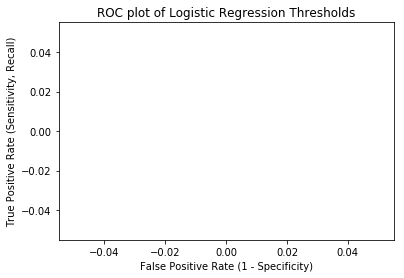

In [424]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


# scaler = StandardScaler().fit(X_train)
# X_train_1 = scaler.transform(X_train)
# X_test_1 = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

# tpr, fpr, thresholds = roc.roc_curve(probabilities, y_test)
tpr, fpr, thresholds = roc_curve(y_test, probabilities, pos_label=2)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Logistic Regression Thresholds")
plt.show()

In [422]:
# scaler = StandardScaler()

alpha = 0.1
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

print( lasso.sparse_coef_)

# remove 0 coefficients 
new_X = X_train.loc[:, lasso.coef_ > 0]
new_X.columns

  (0, 0)	-0.00011155687405737859
  (0, 1)	-7.26643745232587e-05
  (0, 2)	-1.1579428600741251e-05
  (0, 9)	0.0006871441097257111
  (0, 12)	0.0030907665671198537


Index(['srv_count', 'dst_host_count'], dtype='object')

scorer  = make_scorer(sc.rmsle, greater_is_better=True)

#How to manage many models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('EN', Ridge())])))

ScaledLR: 498291499318.944519 (279384318374.669800)
ScaledLASSO: 0.782459 (0.018614)
ScaledRidge: 0.147064 (0.026918)


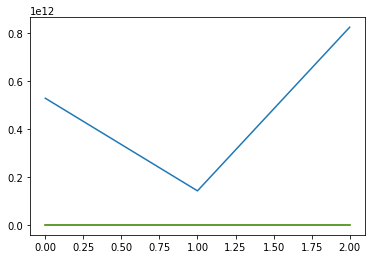

In [407]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=3, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    plt.plot(cv_results)
#     plt.xlabel('n')
#     plt.ylabel('rmse')
#     plt.title('average test rmse vs sample size n');
    
    print(msg)